In [2]:
import math
import os
import time
from typing import Callable, Dict

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from loguru import logger
from vincenty import vincenty

from geo_kpe_multidoc import (GEO_KPE_MULTIDOC_CACHE_PATH,
                              GEO_KPE_MULTIDOC_DATA_PATH)

# from geo_kpe_multidoc.geo.measures import GearyC, GetisOrdG, MoranI

In [1]:
def get_files(path: str):
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            yield file


In [3]:
data = pd.DataFrame()
coordinates = {}
gold = {}

for filename in get_files(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, "MKDUC01")):
    topic_id = filename[:3]
    (
        keyphrase_scores,
        candidates,
        keyphrase_document_matrix,
        keyphrase_coordinates,
        gold_kp,
    ) = joblib.load(os.path.join(GEO_KPE_MULTIDOC_CACHE_PATH, "MKDUC01", filename))

    N = {candidate: len(docs) for candidate, docs in keyphrase_document_matrix.items()}
    keyphrase_scores = {candidate: score for candidate, score in keyphrase_scores}

    topic_data = pd.DataFrame.from_dict(
        keyphrase_scores, orient="index", columns=["semantic_score"]
    )
    topic_data["N"] = pd.DataFrame.from_dict(N, orient="index", columns=["N"])
    topic_data["topic"] = topic_id
    topic_data.index.name = "keyphrase"
    topic_data = topic_data.set_index(["topic", topic_data.index])

    coordinates[topic_id] = keyphrase_coordinates
    gold[topic_id] = gold_kp

    data = pd.concat([data, topic_data])


In [87]:
# extracted keyphrases in gold list for d04 topic
in_gold_scores = pd.Series(dtype=float)
not_gold_scores = pd.Series(dtype=float)

in_gold_N_documents = pd.Series(dtype=int)
not_gold_N_documents = pd.Series(dtype=int)

for topic in data.index.get_level_values(0).unique():
    extracted_gold = data.loc[topic].loc[data.loc[topic, :].index.isin(gold[topic])]
    extracted_not_gold = data.loc[topic].loc[
        ~data.loc[topic, :].index.isin(gold[topic])
    ]

    in_gold_scores = pd.concat([in_gold_scores, extracted_gold["semantic_score"]])
    not_gold_scores = pd.concat([not_gold_scores, extracted_not_gold["semantic_score"]])

    in_gold_N_documents = pd.concat([in_gold_N_documents, extracted_gold["N"]])
    not_gold_N_documents = pd.concat([not_gold_N_documents, extracted_not_gold["N"]])


### Density plot of extracted keyphrase scores (in gold vs non gold)

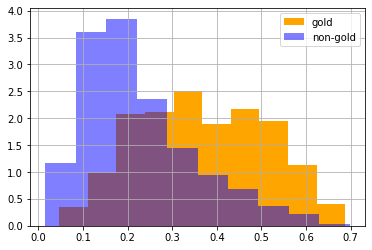

In [88]:
def plot_non_versus_gold_density(gold_values, not_gold_values):
    _, ax = plt.subplots()

    gold_values.hist(ax=ax, density=True, color="orange")
    not_gold_values.hist(ax=ax, alpha=0.5, density=True, color="blue")
    plt.legend(["gold", "non-gold"])
    plt.show()


plot_non_versus_gold_density(in_gold_scores, not_gold_scores)


### Density plot of the Number of documents where the extracted keyphrase shows up

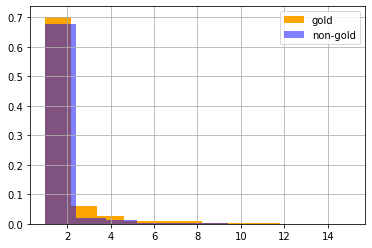

In [89]:
plot_non_versus_gold_density(in_gold_N_documents, not_gold_N_documents)


## Similarity weighting by distance

def w_inv_dist(v: float):

\begin{align}
f(x) = 1 / (a + x) \\
f(x) = exp(- x^a)  \\
f(x) = arccot(ax)  \
\end{align}

In [6]:
def inv_dist(d: np.ndarray, a=1):
    r"""$f(x) = \frac{1}{a + d}$"""
    return 1 / (a + d)


def exp_dist(d: np.ndarray, a=1):
    r"""$f(x) = exp(- x^a)$"""
    return np.e ** (-(d**a))


def arc_dist(d: np.ndarray, a=1):
    r"""$f(x) = arccot(a x)$"""
    return math.arccot(a * d)


def orig_dist(d: np.ndarray):
    return 1.0 / (np.e**d)

from functools import lru_cache

@lru_cache(maxsize=1000)
def cached_vincenty(c1, c2):
    return vincenty(c1, c2)


In [7]:
def preprocess_scores_weight_matrix(
    keyphrase_scores, keyphrase_coordinates, weighting_func
):
    """Build observation scores array (n) and compute similatity matrix (n, n) with weigthed based distance metric.

    n = C (total candidates) * sum of # Coordenates connected with each candidate

    Candidade -(M:N)- Document -(K:L)- GeoCoordinate

    Parameters
    ----------
    keyphrase_scores : _type_
        _description_
    keyphrase_coordinates : _type_
        _description_

    Returns
    -------
    np.array
        Semantic score of each observation (N)
    np.array
        (N, N) array with weighted similatity for all observation pairs.

    """
    scores = []
    coordinates = []
    for key, value_list in keyphrase_coordinates.items():
        for value in value_list:
            scores.append(keyphrase_scores[key])
            coordinates.append(value)
    n = len(scores)
    scores = np.array(scores)

    start = time.time()
    logger.info(f"vincenty dist start n={n}")
    weight_matrix = np.asarray(
        [
            [
                # To exploit caching the function parameter order must be the same.
                # Fortunatly distance is simetric so we keep always the smallest value first.
                # But each coordenate have 2 values threfore we compare on the sum
                # of the coordenates (lat+long vs lat+long).
                cached_vincenty(coordinates[i], coordinates[j])
                if sum(coordinates[i]) <= sum(coordinates[j])
                else cached_vincenty(coordinates[i], coordinates[j])
                for i in range(n)
            ]
            for j in range(n)
        ]
    )
    end = time.time()
    logger.debug("vincenty dist time n={}: {:.1f}".format(n, end - start))

    # transforme distance matrix to similatity measure
    weight_matrix = weighting_func(weight_matrix)

    end = time.time()
    logger.debug("vincenty dist stage 2 time n={}: {:.1f}".format(n, end - start))

    return scores, weight_matrix


def MoranI(scores, weight_matrix):
    n = len(scores)
    mean = np.mean(scores)
    # adjusted_scores = [(score - mean) ** 2 for score in scores]
    # moranI = n / np.sum(adjusted_scores)
    adjusted_scores = scores - mean
    moranI = n / np.sum(adjusted_scores**2)

    outer_mul_scores = np.outer(adjusted_scores, adjusted_scores)
    # for i in range(n):
    #     for j in range(n):
    #         # distance = dist_to_sim(vincenty(coordinates[i], coordinates[j]))
    #         # distance = 1.0 / (np.e ** vincenty(coordinates[i], coordinates[j]))
    #         sum1 += distance_matrix[i][j] * (scores[i] - mean) * (scores[j] - mean)
    #         sum2 += distance_matrix[i][j]

    sum1 = (weight_matrix * outer_mul_scores).sum()  # elementwize product and sum all
    sum2 = weight_matrix.sum()
    moranI = moranI * (sum1 / sum2)
    return moranI


def GearyC(scores, weight_matrix):
    n = len(scores)
    mean = np.mean(scores)
    # sum_adjusted_scores = np.sum([(score - mean) ** 2 for score in scores])
    sum_adjusted_scores = np.sum((scores - mean) ** 2)

    # TODO: vectorize outer difference
    # outer_difference_scores = np.asarray(
    #     [[scores[i] - scores[j] for i in range(n)] for j in range(n)]
    # )
    outer_difference_scores = np.subtract.outer(scores, scores)

    # sum1 = 0.0
    # sum2 = 0.0
    # for i in range(n):
    #     for j in range(n):
    #         # distance = dist_to_sim(vincenty(coordinates[i], coordinates[j]))
    #         # distance = 1.0 / (np.e ** vincenty(coordinates[i], coordinates[j]))
    #         sum1 += distance_matrix[i][j] * ((scores[i] - scores[j]) ** 2)
    #         sum2 += distance_matrix[i][j]

    outer_difference_scores = outer_difference_scores**2
    sum1 = (
        weight_matrix * outer_difference_scores
    ).sum()  # elementwize product and sum all
    sum2 = weight_matrix.sum()

    gearyC = ((n - 1.0) * sum1) / (2.0 * sum2 * sum_adjusted_scores)
    return gearyC


def GetisOrdG(scores, weight_matrix):
    n = len(scores)

    outer_mul_scores = np.outer(np.asarray(scores), np.asarray(scores))

    # for i in range(n):
    #     for j in range(n):
    #         # distance = dist_to_sim(vincenty(coordinates[i], coordinates[j]))
    #         # distance = 1.0 / (np.e ** vincenty(coordinates[i], coordinates[j]))
    #         sum1 += distance_matrix[i][j] * scores[i] * scores[j]
    #         sum2 += scores[i] * scores[j] # this is moved to a np outer product and sum.

    sum1 = (weight_matrix * outer_mul_scores).sum()  # elementwize product and sum all
    sum2 = outer_mul_scores.sum()

    getisOrdG = sum1 / sum2
    return getisOrdG


In [8]:
def _score_w_geo_association_I(S, N, I, lambda_=1, gamma=1):
    return S * lambda_ * (N - (N * gamma * I))


def _score_w_geo_association_C(S, N, C, lambda_=1, gamma=1):
    return S * lambda_ * N / (gamma * C)


def _score_w_geo_association_G(S, N, G, lambda_=0.5, gamma=0.5):
    return S * lambda_ * (N * gamma) * G


In [9]:
def geo_associations(kp_data: pd.DataFrame, coordinates_data: Dict, w_function: Callable):

    # topic is level 0 multiindex of the dataframe
    topic = list(kp_data.index.get_level_values(0))[0]

    coordinates = {
        kp: coordinates_data[topic][kp]
        for kp in kp_data.index.get_level_values(1).to_list()
    }

    scores, w = preprocess_scores_weight_matrix(
        # drop topic from index level
        kp_data["semantic_score"].droplevel(0).to_dict(), coordinates, w_function
    )

    moran_i = MoranI(scores, w) 
    geary_c = GearyC(scores, w)
    getis_g = GetisOrdG(scores, w)

    return (moran_i, geary_c, getis_g)
    

In [ ]:
# extracted_gold_kp = data.loc[topic].loc[data.loc[topic, :].index.isin(gold[topic])]
# extracted_not_gold_kp = data.loc[topic].loc[~data.loc[topic, :].index.isin(gold[topic])]
w_function = inv_dist

# for topic in ["d05"]: # data.index.get_level_values(0): 
for topic in data.index.get_level_values(0).unique(): 
    logger.info(f"Computing geo association for Topic {topic}")
    # Gold
    extracted_gold_kp = data.loc[topic].loc[data.loc[topic, :].index.isin(gold[topic])]
    extracted_gold_kp["topic"] = topic
    extracted_gold_kp = extracted_gold_kp.set_index(["topic", extracted_gold_kp.index])

    moran_i, geary_c ,getis_g = geo_associations(extracted_gold_kp, coordinates, w_function)
    data.loc[extracted_gold_kp.index, ["moran_i", "geary_c", "getis_g"]] = moran_i, geary_c, getis_g

    # Not Gold
    extracted_not_gold_kp = data.loc[topic].loc[~data.loc[topic, :].index.isin(gold[topic])]
    extracted_not_gold_kp["topic"] = topic
    extracted_not_gold_kp = extracted_not_gold_kp.set_index(["topic", extracted_not_gold_kp.index])

    moran_i, geary_c ,getis_g = geo_associations(extracted_not_gold_kp, coordinates, w_function)
    data.loc[extracted_not_gold_kp.index, ["moran_i", "geary_c", "getis_g"]] = moran_i, geary_c, getis_g

data.head()


semantic_score  N   moran_i   geary_c   getis_g
topic keyphrase                                                              
d05   mysterious ailment            0.649598  1  0.012541  1.076137  0.150363
      other disease                 0.609773  1  0.012541  1.076137  0.150363
      brain disorder similar        0.608422  1  0.012541  1.076137  0.150363
      cattle industry               0.588455  2  0.012541  1.076137  0.150363
      microbiology professor        0.582260  1  0.012541  1.076137  0.150363
...                                      ... ..       ...       ...       ...
      new height                    0.045245  1  0.012541  1.076137  0.150363
      mentor                        0.041740  1  0.012541  1.076137  0.150363
      lantern-light                 0.040386  1  0.012541  1.076137  0.150363
      account                       0.039642  1  0.012541  1.076137  0.150363
      handpick adviser              0.039436  1  0.012541  1.076137  0.150363

[791 rows x 5 columns]

In [11]:
moran_i

0.012541373026992732

In [30]:
extracted_gold_kp["semantic_score"].droplevel(0).to_dict()

{'wildfire danger': 0.6226916909217834,
 'record-break fire season': 0.6176967024803162,
 'stubborn wildfire': 0.607688844203949,
 'wildfire battle': 0.5923338532447815,
 'western wildfire': 0.5904080271720886,
 'wildfire smoke': 0.575958788394928,
 'damage wildfire': 0.557585597038269,
 'wildfire precaution': 0.5575099587440491,
 'wildfire command post': 0.5491733551025391,
 'fire ecology': 0.5434836745262146,
 'brush fire': 0.5314204692840576,
 'poisonous stew': 0.5284483432769775,
 'deadly firestorm': 0.5170426964759827,
 'unprecedented fire season': 0.5132861137390137,
 'summer fire': 0.5097019672393799,
 'firescape garden': 0.5007376074790955,
 'fire danger': 0.4921480119228363,
 'fire-resistant landscape': 0.48912134766578674,
 'forest fire practice': 0.4855905771255493,
 'firescapes demonstration garden': 0.4696606397628784,
 'vulnerable fire zone': 0.4653688669204712,
 'high fire hazard': 0.46444883942604065,
 'new wildfire season': 0.46005144715309143,
 'carbon monoxide': 0.45

In [20]:
extracted_gold_kp

,semantic_score,N
keyphrase,,
wildfire danger,0.622692,1
record-break fire season,0.617697,1
stubborn wildfire,0.607689,1
wildfire battle,0.592334,1
western wildfire,0.590408,1
...,...,...
lung function,0.121761,1
aggressive approach,0.113199,1
health service,0.097067,1


#### Before preprocessing and optimized caching

GOLD Keyphrase geo association metrics
vincenty dist time n=514: 0.4686918258666992
vincenty dist stage 2 time n=514: 0.4695897102355957
Moran I =  0.003692239172575906
vincenty dist time n=514: 0.4863090515136719
vincenty dist stage 2 time n=514: 0.48704051971435547
score diff time n=514: 0.6319024562835693
Geary C =  0.9560780297616269
Getis Ord G =  0.09483899110834387
***NOT*** GOLD Keyphrase geo association metrics
vincenty dist time n=7300: 42.76019859313965
vincenty dist stage 2 time n=7300: 45.271119594573975
Moran I =  0.0033173261091216963
vincenty dist time n=7300: 47.825313329696655
vincenty dist stage 2 time n=7300: 50.70021104812622
score diff time n=7300: 89.23232340812683
Geary C =  0.9941197137400668
Getis Ord G =  0.08685842432332495

##### After optimzation

vincenty dist time n=514: 0.5876176357269287
vincenty dist stage 2 time n=514: 0.5895473957061768
GOLD Keyphrase geo association metrics
Moran I =  0.003692239172575906
Geary C =  0.9560780297616269
Getis Ord G =  0.09483899110834387
vincenty dist time n=7300: 75.67063593864441
vincenty dist stage 2 time n=7300: 79.01104664802551
***NOT*** GOLD Keyphrase geo association metrics
Moran I =  0.0033173261091216963
Geary C =  0.9941197137400668
Getis Ord G =  0.08685842432332495

#### After distance function selection

vincenty dist time n=514: 0.6
vincenty dist stage 2 time n=514: 0.6
GOLD Keyphrase geo association metrics
Moran I =  0.003692239172575906
Geary C =  0.9560780297616269
Getis Ord G =  0.09483899110834387
vincenty dist time n=7300: 75.3
vincenty dist stage 2 time n=7300: 77.9
***NOT*** GOLD Keyphrase geo association metrics
Moran I =  0.0033173261091216963
Geary C =  0.9941197137400668
Getis Ord G =  0.08685842432332495


#### Vectorized outer subtraction 

GOLD Keyphrase geo association metrics
vincenty dist time n=514: 0.2
vincenty dist stage 2 time n=514: 0.2
Moran I =  0.003692239172575906
Geary C =  0.9560780297616269
Getis Ord G =  0.09483899110834387
***NOT*** GOLD Keyphrase geo association metrics
vincenty dist time n=7300: 39.3
vincenty dist stage 2 time n=7300: 41.5
Moran I =  0.0033173261091216963
Geary C =  0.9941197137400668
Getis Ord G =  0.08685842432332495


!it is ok!

In [117]:
extracted_gold_kp["semantic_score"].to_dict()


{'severe property damage': 0.6069620847702026,
 'hurricane andrew': 0.5918833613395691,
 'landfall': 0.4840491712093353,
 'disaster loss': 0.46318748593330383,
 'storm-relate injury': 0.43344640731811523,
 'tropical storm': 0.42664268612861633,
 'massive rebuild effort': 0.3767067790031433,
 'insurance claim': 0.34753817319869995,
 'new orleans': 0.3423781991004944,
 'louisiana': 0.32720470428466797,
 'property-casualty industry': 0.32451874017715454,
 'southern florida': 0.3226373791694641,
 'widespread destruction': 0.31998592615127563,
 'insurance industry loss': 0.3147260248661041,
 'emergency service': 0.23720094561576843,
 'president george bush': 0.21786928176879883}

In [116]:
topic_in_gold_coordinates = {
    kp: coordinates[topic][kp]
    for kp in extracted_gold_kp.index.get_level_values(0).to_list()
}


['severe property damage',
 'hurricane andrew',
 'landfall',
 'disaster loss',
 'storm-relate injury',
 'tropical storm',
 'massive rebuild effort',
 'insurance claim',
 'new orleans',
 'louisiana',
 'property-casualty industry',
 'southern florida',
 'widespread destruction',
 'insurance industry loss',
 'emergency service',
 'president george bush']

In [106]:
topic_extracted_in_gold_kp = pd.MultiIndex.from_product(
    [[topic], extracted_gold_kp.index.get_level_values(0)]
)
topic_extracted_not_gold_kp = pd.MultiIndex.from_product(
    [[topic], extracted_not_gold_kp.index.get_level_values(0)]
)
topic_extracted_not_gold_kp


NameError: name 'extracted_not_gold_kp' is not defined

In [108]:
extracted_not_gold_kp


,semantic_score,N
keyphrase,,
further devastate landfall,0.646872,1
northwest,0.622780,2
disaster,0.614563,2
low-lie city,0.613845,1
property damage,0.610528,1
...,...,...
difference,0.043850,1
speech,0.043780,1
course,0.043283,1


In [103]:
data.loc[topic].loc[data.loc[topic, :].index.isin(gold[topic])]


,semantic_score,N
keyphrase,,
severe property damage,0.606962,1
hurricane andrew,0.591883,7
landfall,0.484049,2
disaster loss,0.463187,1
storm-relate injury,0.433446,1
tropical storm,0.426643,1
massive rebuild effort,0.376707,1
insurance claim,0.347538,3
new orleans,0.342378,4
